In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from collections import Counter
from sklearn.model_selection import  GroupKFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import polars as pl

In [2]:
np.random.seed(42)

In [3]:
class Config:
    TRAIN_PATH = '../inputs/train.csv'
    TEST_PATH = '../inputs/test.csv'
    TRAIN_LABELS = '../inputs/train_labels.csv'
    SAMPLE_SUBMISSION = '../inputs/sample_submission.csv'

In [4]:
def q2l(x):
    if x <= 3:
        return '0-4'
    if x <= 13:
        return '5-12'
    return '13-22'

In [5]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']
event_features =  ['cutscene_click', 'person_click', 'navigate_click',
                   'observation_click', 'notification_click', 'object_click',
                   'object_hover', 'map_hover', 'map_click', 'notebook_click']
room_features = ['historicalsociety',
          'kohlcenter',
          'capitol_0',
          'humanecology',
          'drycleaner',
          'library',
          'capitol_1',
          'wildlife',
          'flaghouse','capitol_2']
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']

name_features = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click',
       'notebook_click']
room_events = [
 'map_click_library',
 'navigate_click_library',
 'notification_click_library',
 'notebook_click_library',
 'cutscene_click_library',
 'person_click_library',
 'observation_click_library',
 'object_hover_library',
 'map_hover_library',
 'object_click_library',
 'notebook_click_capitol_1',
 'cutscene_click_capitol_1',
 'person_click_capitol_1',
 'notification_click_capitol_1',
 'observation_click_capitol_1',
 'map_click_capitol_1',
 'navigate_click_capitol_1',
 'object_click_capitol_1',
 'map_hover_capitol_1',
 'object_hover_capitol_1',
 'map_click_historicalsociety',
 'object_click_historicalsociety',
 'map_hover_historicalsociety',
 'person_click_historicalsociety',
 'notification_click_historicalsociety',
 'cutscene_click_historicalsociety',
 'observation_click_historicalsociety',
 'navigate_click_historicalsociety',
 'notebook_click_historicalsociety',
 'object_hover_historicalsociety',
 'person_click_flaghouse',
 'notebook_click_flaghouse',
 'observation_click_flaghouse',
 'map_hover_flaghouse',
 'notification_click_flaghouse',
 'map_click_flaghouse',
 'object_hover_flaghouse',
 'object_click_flaghouse',
 'cutscene_click_flaghouse',
 'navigate_click_flaghouse',
 'map_click_wildlife',
 'notification_click_wildlife',
 'cutscene_click_wildlife',
 'map_hover_wildlife',
 'object_click_wildlife',
 'observation_click_wildlife',
 'navigate_click_wildlife',
 'object_hover_wildlife',
 'person_click_wildlife',
 'notebook_click_wildlife',
 'observation_click_drycleaner',
 'person_click_drycleaner',
 'notebook_click_drycleaner',
 'map_hover_drycleaner',
 'map_click_drycleaner',
 'object_hover_drycleaner',
 'cutscene_click_drycleaner',
 'notification_click_drycleaner',
 'navigate_click_drycleaner',
 'object_click_drycleaner',
 'navigate_click_capitol_2',
 'object_hover_capitol_2',
 'object_click_capitol_2',
 'cutscene_click_capitol_2',
 'observation_click_capitol_2',
 'notebook_click_capitol_2',
 'notification_click_capitol_2',
 'person_click_capitol_2',
 'map_hover_capitol_2',
 'map_click_capitol_2',
 'cutscene_click_humanecology',
 'map_hover_humanecology',
 'object_hover_humanecology',
 'observation_click_humanecology',
 'notebook_click_humanecology',
 'map_click_humanecology',
 'navigate_click_humanecology',
 'person_click_humanecology',
 'notification_click_humanecology',
 'object_click_humanecology',
 'cutscene_click_capitol_0',
 'notebook_click_capitol_0',
 'navigate_click_capitol_0',
 'object_hover_capitol_0',
 'map_click_capitol_0',
 'person_click_capitol_0',
 'object_click_capitol_0',
 'observation_click_capitol_0',
 'map_hover_capitol_0',
 'notification_click_capitol_0',
 'object_click_kohlcenter',
 'observation_click_kohlcenter',
 'notebook_click_kohlcenter',
 'person_click_kohlcenter',
 'notification_click_kohlcenter',
 'map_click_kohlcenter',
 'cutscene_click_kohlcenter',
 'object_hover_kohlcenter',
 'navigate_click_kohlcenter',
 'map_hover_kohlcenter']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']
DIALOGS = ['that', 'this', 'it', 'you','find','found','Found','notebook','Wells','wells','help','need', 'Oh','Ooh','Jo', 'flag', 'can','and','is','the','to']
LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]
name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']

In [6]:
columns = [
    (pl.col('level') - pl.col('level').shift(1)).over('session_id','level_group').alias('level_shift'),
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
         .abs()
         .over(["session_id", "level_group"])
        .alias("location_x_diff") 
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
         .abs()
         .over(["session_id", "level_group"])
        .alias("location_y_diff") 
    ),
    (pl.col("event_name").filter(pl.col("event_name") == 'checkpoint')
        .count().over(["session_id", "level_group"]).alias('n_checkpoint')),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None"),
    pl.col('room_fqid').str.split('.').arr[1].alias('main_room')
]

In [7]:
df = (pl.read_csv(Config.TRAIN_PATH)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))

In [8]:
targets = pd.read_csv(Config.TRAIN_LABELS)
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

(424116, 4)


In [9]:
# df=df.with_columns((pl.col('event_name') + '_' + pl.col('main_room')).alias('room_event'))
# df1 = df.filter((pl.col("level_group")=='0-4')&(pl.col('n_checkpoint')==1))
# df2 = df.filter((pl.col("level_group")=='5-12')&(pl.col('n_checkpoint')==1))
# df3 = df.filter((pl.col("level_group")=='13-22')&(pl.col('n_checkpoint')==1))
# df1.shape,df2.shape,df3.shape

In [10]:
df=df.with_columns((pl.col('event_name') + '_' + pl.col('main_room')).alias('room_event'))
df1 = df.filter((pl.col("level_group")=='0-4'))
df2 = df.filter((pl.col("level_group")=='5-12'))
df3 = df.filter((pl.col("level_group")=='13-22'))
df1.shape,df2.shape,df3.shape

((3981005, 24), (8844238, 24), (13471703, 24))

In [11]:
del df
gc.collect()

0

In [12]:
level_limit = {'0-4':(1,5),'5-12':(5,13),'13-22':(13,23)}

In [13]:
def feature_engineering_df1(x):
    LEVELS = [0, 1, 2, 3, 4]
    ROOM_EVENTS = ['cutscene_click_historicalsociety', 'notification_click_kohlcenter', 'object_hover_kohlcenter', 'navigate_click_capitol_0',
                   'navigate_click_kohlcenter', 'cutscene_click_capitol_0', 'notebook_click_kohlcenter', 'navigate_click_historicalsociety',
                   'person_click_historicalsociety', 'map_hover_capitol_0', 'map_click_capitol_0', 'map_click_historicalsociety',
                   'cutscene_click_kohlcenter', 'notification_click_historicalsociety', 'object_click_historicalsociety',
                   'map_hover_kohlcenter','observation_click_historicalsociety','map_click_kohlcenter','notebook_click_historicalsociety',
                   'object_click_kohlcenter','object_hover_historicalsociety','observation_click_kohlcenter', 'map_hover_historicalsociety']
    FQID_LISTS = ['tunic.capitol_0', 'tunic.kohlcenter', 'plaque.face.date', 'fqid_None', 'tunic', 'block_tomap2','photo',
                  'plaque','cs','block_tomap1','tobasement','block_tocollection','block_0','wells','directory','tocollection',
                  'teddy','report','doorblock','tomap','outtolunch','groupconvo','tunic.hub.slip','tostacks','tocloset','notebook',
                  'togrampa','retirement_letter','intro','toentry','janitor','chap1_finale','boss','chap1_finale_c','tunic.historicalsociety','gramps']
    TEXT_LISTS = ['tunic.historicalsociety.closet.teddy.intro_0_cs_0','tunic.kohlcenter.halloffame.plaque.face.date','tunic.historicalsociety.closet.doorblock',
                  'tunic.historicalsociety.collection.cs','tunic.historicalsociety.closet.notebook','tunic.historicalsociety.closet.intro',
                  'tunic.historicalsociety.basement.janitor','tunic.historicalsociety.closet.photo','tunic.historicalsociety.collection.gramps.lost',
                  'tunic.historicalsociety.stacks.outtolunch','tunic.historicalsociety.entry.block_tocollection','tunic.historicalsociety.collection.gramps.found',
                  'text_fqid_None','tunic.historicalsociety.collection.tunic.slip','tunic.kohlcenter.halloffame.block_0','tunic.capitol_0.hall.chap1_finale_c',
                  'tunic.kohlcenter.halloffame.togrampa','tunic.historicalsociety.closet.gramps.intro_0_cs_0','tunic.historicalsociety.entry.block_tomap2',
                  'tunic.historicalsociety.entry.boss.talktogramps','tunic.historicalsociety.entry.gramps.hub','tunic.historicalsociety.collection.tunic',
                  'tunic.historicalsociety.closet.retirement_letter.hub','tunic.historicalsociety.entry.wells.talktogramps',
                  'tunic.historicalsociety.closet.teddy.intro_0_cs_5','tunic.historicalsociety.entry.block_tomap1','tunic.historicalsociety.entry.groupconvo',
                  'tunic.historicalsociety.collection.gramps.look_0']
    aggs = [
          pl.col("index").count().alias(f"session_number"),
        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).max().alias(f'word_max_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).sum().alias(f'word_sum_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).median().alias(f'word_median_{c}') for c
          in DIALOGS],
    pl.col('level_shift').min().alias('level_shift_min'),
    pl.col('level_shift').apply(lambda x: x < 0).count().alias('n_level_shift_negative'),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .mean().alias(f"elapsed_time_diff_level_shift_negative_mean"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .std().alias(f"elapsed_time_diff_level_shift_negative_std"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .min().alias(f"elapsed_time_diff_level_shift_negative_min"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .min().alias(f"elapsed_time_diff_level_shift_negative_max"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .mean().alias(f"elapsed_time_diff_level_shift_positive_mean"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .std().alias(f"elapsed_time_diff_level_shift_positive_std"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .min().alias(f"elapsed_time_diff_level_shift_positive_min"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .min().alias(f"elapsed_time_diff_level_shift_positive_max"), 
         
    (pl.col('elapsed_time').apply(lambda x: x.max() - x.min())).alias('duration'),
    *[pl.col("elapsed_time").filter(pl.col("level") == i)
      .apply(lambda x: x.max() - x.min() if len(x) > 0 else 0)
      .alias(f'duration_level_{i}') for i in LEVELS],
    (pl.col('text_fqid').is_null().count().alias('text_fqid_null')),
         
    (pl.col('hover_duration').sum()
     .alias(f"hover_duration_sum")),
    (pl.col('hover_duration').std()
     .alias(f"hover_duration_std")),
    (pl.col('hover_duration').max()
     .alias(f"hover_duration_max")),
    (pl.col('hover_duration').min()
     .alias(f"hover_duration_min")),
    *[pl.col("hover_duration").filter(pl.col("level") == i)
      .sum().alias(f'hover_duration_level_{i}') for i in LEVELS],
    (pl.col('elapsed_time_diff').mean()
     .alias(f"elapsed_time_diff_mean")),
    (pl.col('elapsed_time_diff').std()
     .alias(f"elapsed_time_diff_std")),
    (pl.col('elapsed_time_diff').max()
     .alias(f"elapsed_time_diff_max")),
    (pl.col('elapsed_time_diff').min()
     .alias(f"elapsed_time_diff_min")),
    *[pl.col("room_event").filter(pl.col("room_event") == c)
        .count().alias(f"{c}_room_event_counts") 
      for c in ROOM_EVENTS],
    *[pl.col("event_name").filter(pl.col("event_name") == c)
        .count().alias(f"{c}_event_counts") 
      for c in event_features],

    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in event_features],
         
    *[pl.col("fqid").filter(pl.col("fqid") == c)
        .count().alias(f"{c}_fqid_counts") 
      for c in FQID_LISTS],
   
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in FQID_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in FQID_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in FQID_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in FQID_LISTS],
    *[pl.col("text_fqid").filter(pl.col("text_fqid") == c)
        .count().alias(f"{c}_text_fqid_counts")
      for c in TEXT_LISTS],

    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in TEXT_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in TEXT_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in TEXT_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in TEXT_LISTS],

    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_x") for c in event_features]
    
 
]                         
    for l in LEVELS:
        for c in event_features:
            aggs.append(pl.col("index").filter((pl.col("event_name")==c) & (pl.col('level')==l)).count().alias(f'{c}_level_{l}_count'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.max(np.diff(x))).alias(f'ET_between_{c}_level_{l}_max'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.min(np.diff(x))).alias(f'ET_between_{c}_level_{l}_min'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.mean(np.diff(x))).alias(f'ET_between_{c}_level_{l}_mean'))
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
    for col1 in event_features:
        for col2 in event_features:
            if col1!=col2:                     
                df = df.with_columns([pl.struct([f'{col1}_event_counts',f'{col2}_event_counts'])\
                                          .apply(lambda x: x[f'{col1}_event_counts']/(x[f'{col1}_event_counts']+x[f'{col2}_event_counts']+1))\
                                          .alias(f'{col1}/({col1}+{col2})')])
    df = df.with_columns([pl.struct(['duration', 'hover_duration_sum']).apply(lambda x: 0 if not x['hover_duration_sum']  else x['duration'] - x['hover_duration_sum']).alias('active_time'),
                          pl.struct(['hover_duration_sum','session_number']).apply(lambda x: 0 if not x['hover_duration_sum'] else x['hover_duration_sum']/x['session_number'])
                          .alias('hover_duration_per_event')])
    return df.to_pandas()

In [14]:
def feature_engineering_df2(x,  use_extra=False):
    LEVELS = [5,6,7,8,9,10,11,12]
    ROOM_EVENTS = ['map_hover_capitol_1', 'notebook_click_humanecology', 'notebook_click_library', 'person_click_drycleaner', 'map_click_historicalsociety', 
                   'navigate_click_historicalsociety', 'notification_click_humanecology', 'map_click_humanecology', 'notebook_click_historicalsociety', 
                   'map_click_library', 'map_hover_humanecology', 'object_hover_drycleaner', 'observation_click_historicalsociety', 'cutscene_click_historicalsociety', 
                   'person_click_historicalsociety', 'navigate_click_drycleaner', 'observation_click_library', 'map_click_drycleaner', 'navigate_click_capitol_0', 
                   'object_hover_kohlcenter', 'cutscene_click_library', 'notification_click_drycleaner', 'notebook_click_kohlcenter', 'navigate_click_humanecology', 
                   'notebook_click_drycleaner', 'navigate_click_library', 'object_click_drycleaner', 'map_hover_capitol_0', 
                   'object_hover_humanecology', 'navigate_click_kohlcenter', 'observation_click_drycleaner', 'person_click_humanecology', 'map_hover_kohlcenter',
                   'notification_click_historicalsociety', 'object_click_library', 'map_click_capitol_1', 'object_click_kohlcenter', 'map_hover_drycleaner', 
                   'person_click_capitol_0', 'object_hover_historicalsociety', 'person_click_capitol_1', 'person_click_library', 'map_hover_historicalsociety', 
                   'cutscene_click_capitol_1', 'object_click_humanecology', 'navigate_click_capitol_1', 'map_click_capitol_0', 'map_click_kohlcenter', 
                   'observation_click_humanecology', 'object_click_historicalsociety', 'notification_click_library', 'map_hover_library', 'object_hover_library']
    FQID_LISTS = ['tobasement', 'toentry', 'tohallway', 'businesscards.card_1.next', 'chap2_finale_c', 'chap2_finale', 'journals.pic_2.next', 'tunic.library', 
                  'magnify', 'janitor', 'reader.paper0.prev', 'trigger_scarf', 'archivist', 'reader.paper2.prev', 'door_block_talk', 'tomap', 'reader.paper2.bingo', 
                  'block', 'journals', 'tostacks', 'businesscards.card_bingo.next', 'reader', 'tunic.drycleaner', 'tunic', 'businesscards.card_0.next', 
                  'journals.hub.topics', 'businesscards', 'outtolunch', 'journals.pic_1.next', 'tocloset_dirty', 'reader.paper2.next', 'logbook.page.bingo', 
                  'tunic.capitol_0', 'tunic.historicalsociety', 'tomicrofiche', 'reader.paper0.next', 'tocollection', 'gramps', 'wellsbadge', 'reader.paper1.prev', 
                  'businesscards.card_bingo.bingo', 'tunic.humanecology', 'plaque', 'directory', 'door_block_clean', 'block_badge_2', 'block_badge', 'trigger_coffee', 
                  'journals.pic_2.bingo', 'journals.pic_0.next', 'photo', 'block_1', 'block_magnify', 'tunic.kohlcenter', 'tofrontdesk', 'tunic.hub.slip', 
                  'reader.paper1.next', 'tunic.capitol_1', 'fqid_None', 'what_happened', 'logbook', 'worker', 'block_0', 'boss']
    TEXT_LISTS = ['tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 
                  'tunic.drycleaner.frontdesk.worker.done2', 'tunic.historicalsociety.basement.janitor', 
                  'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 
                  'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.stacks.outtolunch', 
                  'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.historicalsociety.frontdesk.magnify', 
                  'tunic.capitol_1.hall.chap2_finale_c', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.library.frontdesk.worker.hello', 
                  'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.drycleaner.frontdesk.worker.done', 
                  'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.drycleaner.frontdesk.block_0', 
                  'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.library.frontdesk.worker.preflag', 'tunic.library.frontdesk.worker.droppedbadge', 
                  'tunic.library.frontdesk.block_badge_2', 'tunic.capitol_1.hall.boss.haveyougotit', 'text_fqid_None', 'tunic.drycleaner.frontdesk.worker.hub', 
                  'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 
                  'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.library.microfiche.reader.paper2.bingo', 
                  'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.humanecology.frontdesk.block_1', 
                  'tunic.library.microfiche.block_0', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.library.frontdesk.worker.hello_short', 
                  'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 
                  'tunic.drycleaner.frontdesk.block_1', 'tunic.library.frontdesk.block_badge', 'tunic.humanecology.frontdesk.worker.intro',
                  'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.humanecology.frontdesk.block_0', 
                  'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 
                  'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.historicalsociety.frontdesk.block_magnify']
    aggs = [
          pl.col("index").count().alias(f"session_number"),
        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).max().alias(f'word_max_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).sum().alias(f'word_sum_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).median().alias(f'word_median_{c}') for c
          in DIALOGS],
    pl.col('level_shift').min().alias('level_shift_min'),
    pl.col('level_shift').apply(lambda x: x < 0).count().alias('n_level_shift_negative'),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .mean().alias(f"elapsed_time_diff_level_shift_negative_mean"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .std().alias(f"elapsed_time_diff_level_shift_negative_std"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .min().alias(f"elapsed_time_diff_level_shift_negative_min"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .min().alias(f"elapsed_time_diff_level_shift_negative_max"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .mean().alias(f"elapsed_time_diff_level_shift_positive_mean"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .std().alias(f"elapsed_time_diff_level_shift_positive_std"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .min().alias(f"elapsed_time_diff_level_shift_positive_min"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .min().alias(f"elapsed_time_diff_level_shift_positive_max"), 
         
    (pl.col('elapsed_time').apply(lambda x: x.max() - x.min())).alias('duration'),
    *[pl.col("elapsed_time").filter(pl.col("level") == i)
      .apply(lambda x: x.max() - x.min() if len(x) > 0 else 0)
      .alias(f'duration_level_{i}') for i in LEVELS],
    (pl.col('text_fqid').is_null().count().alias('text_fqid_null')),
         
    (pl.col('hover_duration').sum()
     .alias(f"hover_duration_sum")),
    (pl.col('hover_duration').std()
     .alias(f"hover_duration_std")),
    (pl.col('hover_duration').max()
     .alias(f"hover_duration_max")),
    (pl.col('hover_duration').min()
     .alias(f"hover_duration_min")),
    *[pl.col("hover_duration").filter(pl.col("level") == i)
      .sum().alias(f'hover_duration_level_{i}') for i in LEVELS],
    (pl.col('elapsed_time_diff').mean()
     .alias(f"elapsed_time_diff_mean")),
    (pl.col('elapsed_time_diff').std()
     .alias(f"elapsed_time_diff_std")),
    (pl.col('elapsed_time_diff').max()
     .alias(f"elapsed_time_diff_max")),
    (pl.col('elapsed_time_diff').min()
     .alias(f"elapsed_time_diff_min")),
    *[pl.col("room_event").filter(pl.col("room_event") == c)
        .count().alias(f"{c}_room_event_counts") 
      for c in ROOM_EVENTS],
    *[pl.col("event_name").filter(pl.col("event_name") == c)
        .count().alias(f"{c}_event_counts") 
      for c in event_features],

    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in event_features],
         
    *[pl.col("fqid").filter(pl.col("fqid") == c)
        .count().alias(f"{c}_fqid_counts") 
      for c in FQID_LISTS],
   
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in FQID_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in FQID_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in FQID_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in FQID_LISTS],
    *[pl.col("text_fqid").filter(pl.col("text_fqid") == c)
        .count().alias(f"{c}_text_fqid_counts")
      for c in TEXT_LISTS],

    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in TEXT_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in TEXT_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in TEXT_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in TEXT_LISTS],

    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_x") for c in event_features]
              
]                         
    for l in LEVELS:
        for c in event_features:
            aggs.append(pl.col("index").filter((pl.col("event_name")==c) & (pl.col('level')==l)).count().alias(f'{c}_level_{l}_count'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.max(np.diff(x))).alias(f'ET_between_{c}_level_{l}_max'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.min(np.diff(x))).alias(f'ET_between_{c}_level_{l}_min'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.mean(np.diff(x))).alias(f'ET_between_{c}_level_{l}_mean'))
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
    for col1 in event_features:
        for col2 in event_features:
            if col1!=col2:                       
                df = df.with_columns([pl.struct([f'{col1}_event_counts',f'{col2}_event_counts'])\
                                          .apply(lambda x: x[f'{col1}_event_counts']/(x[f'{col1}_event_counts']+x[f'{col2}_event_counts']+1))\
                                          .alias(f'{col1}/({col1}+{col2})')])
    df = df.with_columns([pl.struct(['duration', 'hover_duration_sum']).apply(lambda x: 0 if not x['hover_duration_sum']  else x['duration'] - x['hover_duration_sum']).alias('active_time'),
                          pl.struct(['hover_duration_sum','session_number']).apply(lambda x: 0 if not x['hover_duration_sum'] else x['hover_duration_sum']/x['session_number'])
                          .alias('hover_duration_per_event')])
    if use_extra:
        aggs = [
            pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
            pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
            pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_duration"),
            pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
            pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_duration"),
            pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
        ]
        tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
        df = df.join(tmp, on="session_id", how='left')
    return df.to_pandas()

In [15]:
def feature_engineering_df3(x,  use_extra=False):
    LEVELS = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
    ROOM_EVENTS = ['person_click_drycleaner', 'object_click_flaghouse', 'notification_click_historicalsociety', 'notebook_click_humanecology', 
                   'map_hover_kohlcenter', 'observation_click_historicalsociety', 'map_hover_flaghouse', 'navigate_click_capitol_2', 
                   'navigate_click_wildlife', 'navigate_click_drycleaner', 'object_click_historicalsociety', 'person_click_library', 
                   'navigate_click_library', 'observation_click_wildlife', 'navigate_click_humanecology', 'navigate_click_flaghouse', 
                   'map_click_drycleaner', 'object_hover_kohlcenter', 'object_hover_wildlife', 'object_hover_drycleaner', 'notification_click_library', 
                   'object_hover_historicalsociety', 'person_click_historicalsociety', 'map_hover_drycleaner', 'map_hover_library', 'object_hover_library', 
                   'object_click_drycleaner', 'object_hover_flaghouse', 'cutscene_click_historicalsociety', 'map_click_historicalsociety', 
                   'map_click_wildlife', 'notebook_click_library', 'map_hover_capitol_2', 'map_click_library', 
                   'map_hover_humanecology', 'object_click_kohlcenter', 'person_click_capitol_2', 'navigate_click_kohlcenter', 'map_click_flaghouse', 
                   'notification_click_flaghouse', 'notebook_click_drycleaner', 'map_click_kohlcenter', 'object_click_library', 'notebook_click_kohlcenter', 
                   'object_click_humanecology', 'notebook_click_historicalsociety', 'observation_click_library', 'notebook_click_flaghouse', 
                   'cutscene_click_capitol_2', 'person_click_flaghouse', 'notebook_click_wildlife', 'person_click_capitol_1', 'map_click_humanecology', 
                   'person_click_wildlife', 'map_hover_capitol_1', 'person_click_humanecology', 'map_click_capitol_1', 'map_click_capitol_2', 
                   'map_hover_historicalsociety', 'navigate_click_historicalsociety', 'notification_click_wildlife', 'map_hover_wildlife', 
                   'object_click_wildlife', 'object_hover_humanecology', 'navigate_click_capitol_1']
    FQID_LISTS = ['tomap', 'tobasement', 'tunic.wildlife', 'reader.paper0.prev', 'archivist_glasses', 'key', 'journals_flag.pic_0_old.next', 
                  'journals_flag', 'journals_flag.pic_0.bingo', 'journals.pic_1.next', 'tocage', 'savedteddy', 'reader.paper1.prev', 'directory', 
                  'remove_cup', 'reader_flag.paper1.next', 'tocollection', 'lockeddoor', 'journals', 'tohallway', 'tunic.humanecology', 'tostacks', 
                  'teddy', 'tunic.library', 'reader.paper2.next', 'boss', 'reader_flag.paper2.prev', 'journals.hub.topics', 
                  'journals_flag.pic_1_old.next', 'reader_flag.paper2.next', 'fqid_None', 'colorbook', 'tocloset_dirty', 'seescratches', 'block_nelson', 
                  'journals_flag.pic_0.next', 'directory.closeup.archivist', 'chap4_finale_c', 'journals_flag.hub.topics', 'tunic.capitol_1', 
                  'reader_flag.paper0.prev', 'gramps', 'reader.paper2.prev', 'reader_flag.paper1.prev', 'glasses', 'crane_ranger', 'tunic.flaghouse', 
                  'tunic.kohlcenter', 'journals.pic_2.next', 'reader_flag.paper2.bingo', 'expert', 'tunic.capitol_2', 'toentry', 'tofrontdesk', 
                  'need_glasses', 'businesscards.card_0.next', 'reader', 'tunic.historicalsociety', 'journals_flag.pic_1.next', 'wells', 'tomicrofiche', 
                  'businesscards.card_1.next', 'groupconvo_flag', 'journals.pic_0.next', 'journals_flag.hub.topics_old', 'journals_flag.pic_2_old.next', 
                  'photo', 'tracks.hub.deer', 'worker', 'businesscards.card_bingo.next', 'confrontation', 'logbook', 'plaque', 'fox', 'tocollectionflag', 
                  'tunic.drycleaner', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'reader_flag', 'tunic.hub.slip', 'reader.paper0.next', 
                  'businesscards', 'coffee', 'outtolunch', 'tunic', 'reader.paper1.next', 'journals.pic_2.bingo', 'flag_girl', 'ch3start', 
                  'reader_flag.paper0.next', 'unlockdoor', 'journals_flag.pic_1.bingo', 'tracks']
    TEXT_LISTS = ['tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.capitol_2.hall.boss.haveyougotit', 
                  'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.wildlife.center.expert.recap', 
                  'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.basement.seescratches', 
                  'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 
                  'tunic.library.frontdesk.worker.flag_recap', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.basement.gramps.whatdo', 
                  'tunic.wildlife.center.remove_cup', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.capitol_2.hall.chap4_finale_c', 
                  'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.humanecology.frontdesk.worker.badger', 
                  'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.flaghouse.entry.colorbook', 
                  'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 
                  'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.historicalsociety.stacks.outtolunch', 
                  'tunic.historicalsociety.cage.teddy.trapped', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.wildlife.center.wells.nodeer', 
                  'tunic.historicalsociety.cage.confrontation', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.historicalsociety.collection_flag.gramps.flag', 
                  'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.preflag', 
                  'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.cage.need_glasses', 'tunic.historicalsociety.entry.directory.closeup.archivist', 
                  'tunic.historicalsociety.frontdesk.key', 'tunic.historicalsociety.basement.ch3start', 'tunic.wildlife.center.coffee', 'tunic.wildlife.center.wells.animals', 
                  'tunic.historicalsociety.basement.savedteddy', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.entry.wells.flag', 
                  'tunic.wildlife.center.fox.concern', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.historicalsociety.entry.boss.flag', 
                  'text_fqid_None', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.wildlife.center.wells.animals2', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 
                  'tunic.wildlife.center.crane_ranger.crane', 'tunic.library.frontdesk.block_nelson', 'tunic.library.frontdesk.worker.flag']
    aggs = [
          pl.col("index").count().alias(f"session_number"),
        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).max().alias(f'word_max_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).sum().alias(f'word_sum_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).median().alias(f'word_median_{c}') for c
          in DIALOGS],
    pl.col('level_shift').min().alias('level_shift_min'),
    pl.col('level_shift').apply(lambda x: x < 0).count().alias('n_level_shift_negative'),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .mean().alias(f"elapsed_time_diff_level_shift_negative_mean"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .std().alias(f"elapsed_time_diff_level_shift_negative_std"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .min().alias(f"elapsed_time_diff_level_shift_negative_min"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .min().alias(f"elapsed_time_diff_level_shift_negative_max"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .mean().alias(f"elapsed_time_diff_level_shift_positive_mean"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .std().alias(f"elapsed_time_diff_level_shift_positive_std"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .min().alias(f"elapsed_time_diff_level_shift_positive_min"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .min().alias(f"elapsed_time_diff_level_shift_positive_max"), 
         
    (pl.col('elapsed_time').apply(lambda x: x.max() - x.min())).alias('duration'),
    *[pl.col("elapsed_time").filter(pl.col("level") == i)
      .apply(lambda x: x.max() - x.min() if len(x) > 0 else 0)
      .alias(f'duration_level_{i}') for i in LEVELS],
    (pl.col('text_fqid').is_null().count().alias('text_fqid_null')),
         
    (pl.col('hover_duration').sum()
     .alias(f"hover_duration_sum")),
    (pl.col('hover_duration').std()
     .alias(f"hover_duration_std")),
    (pl.col('hover_duration').max()
     .alias(f"hover_duration_max")),
    (pl.col('hover_duration').min()
     .alias(f"hover_duration_min")),
    *[pl.col("hover_duration").filter(pl.col("level") == i)
      .sum().alias(f'hover_duration_level_{i}') for i in LEVELS],
    (pl.col('elapsed_time_diff').mean()
     .alias(f"elapsed_time_diff_mean")),
    (pl.col('elapsed_time_diff').std()
     .alias(f"elapsed_time_diff_std")),
    (pl.col('elapsed_time_diff').max()
     .alias(f"elapsed_time_diff_max")),
    (pl.col('elapsed_time_diff').min()
     .alias(f"elapsed_time_diff_min")),
    *[pl.col("room_event").filter(pl.col("room_event") == c)
        .count().alias(f"{c}_room_event_counts") 
      for c in ROOM_EVENTS],
    *[pl.col("event_name").filter(pl.col("event_name") == c)
        .count().alias(f"{c}_event_counts") 
      for c in event_features],

    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in event_features],
         
    *[pl.col("fqid").filter(pl.col("fqid") == c)
        .count().alias(f"{c}_fqid_counts") 
      for c in FQID_LISTS],
   
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in FQID_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in FQID_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in FQID_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in FQID_LISTS],
    *[pl.col("text_fqid").filter(pl.col("text_fqid") == c)
        .count().alias(f"{c}_text_fqid_counts")
      for c in TEXT_LISTS],

    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in TEXT_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in TEXT_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in TEXT_LISTS],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in TEXT_LISTS],

    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_x") for c in event_features]
              
]                         
    for l in LEVELS:
        for c in event_features:
            aggs.append(pl.col("index").filter((pl.col("event_name")==c) & (pl.col('level')==l)).count().alias(f'{c}_level_{l}_count'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.max(np.diff(x))).alias(f'ET_between_{c}_level_{l}_max'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.min(np.diff(x))).alias(f'ET_between_{c}_level_{l}_min'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.mean(np.diff(x))).alias(f'ET_between_{c}_level_{l}_mean'))
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
    for col1 in event_features:
        for col2 in event_features:
            if col1!=col2:                   
                df = df.with_columns([pl.struct([f'{col1}_event_counts',f'{col2}_event_counts'])\
                                          .apply(lambda x: x[f'{col1}_event_counts']/(x[f'{col1}_event_counts']+x[f'{col2}_event_counts']+1))\
                                          .alias(f'{col1}/({col1}+{col2})')])
    df = df.with_columns([pl.struct(['duration', 'hover_duration_sum']).apply(lambda x: 0 if not x['hover_duration_sum']  else x['duration'] - x['hover_duration_sum']).alias('active_time'),
                          pl.struct(['hover_duration_sum','session_number']).apply(lambda x: 0 if not x['hover_duration_sum'] else x['hover_duration_sum']/x['session_number'])
                          .alias('hover_duration_per_event')])
    if use_extra:
        aggs = [
            pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
            pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
            pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_duration"),
            pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
            pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_duration"),
            pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
        ]
        tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
        df = df.join(tmp, on="session_id", how='left')
    return df.to_pandas()

In [16]:
def feature_engineer(x, grp, use_extra):
    aggs = [
          pl.col("index").count().alias(f"session_number"),
        *[pl.col('index').filter(pl.col('text').str.contains(c)).count().alias(f'word_{c}') for c in DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).mean().alias(f'word_mean_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).std().alias(f'word_std_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).max().alias(f'word_max_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).sum().alias(f'word_sum_{c}') for c in
          DIALOGS],
        *[pl.col("elapsed_time_diff").filter((pl.col('text').str.contains(c))).median().alias(f'word_median_{c}') for c
          in DIALOGS],
    pl.col('level_shift').min().alias('level_shift_min'),
    pl.col('level_shift').apply(lambda x: x < 0).count().alias('n_level_shift_negative'),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .mean().alias(f"elapsed_time_diff_level_shift_negative_mean"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .std().alias(f"elapsed_time_diff_level_shift_negative_std"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .min().alias(f"elapsed_time_diff_level_shift_negative_min"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
        .min().alias(f"elapsed_time_diff_level_shift_negative_max"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .mean().alias(f"elapsed_time_diff_level_shift_positive_mean"),
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .std().alias(f"elapsed_time_diff_level_shift_positive_std"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .min().alias(f"elapsed_time_diff_level_shift_positive_min"), 
    pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
        .min().alias(f"elapsed_time_diff_level_shift_positive_max"), 
    (pl.col('elapsed_time').apply(lambda x: x.max() - x.min())).alias('duration'),
    *[pl.col("elapsed_time").filter(pl.col("level") == i)
      .apply(lambda x: x.max() - x.min() if len(x) > 0 else 0)
      .alias(f'duration_level_{i}') for i in range(5,23)],
    # *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique") for c in CATS],
    (pl.col('text_fqid').is_null().count().alias('text_fqid_null')),
    (pl.col('hover_duration').sum()
     .alias(f"hover_duration_sum")),
    (pl.col('hover_duration').std()
     .alias(f"hover_duration_std")),
    (pl.col('hover_duration').max()
     .alias(f"hover_duration_max")),
    (pl.col('hover_duration').min()
     .alias(f"hover_duration_min")),
    *[pl.col("hover_duration").filter(pl.col("level") == i)
      .sum().alias(f'hover_duration_level_{i}') for i in range(5,23)],
    (pl.col('elapsed_time_diff').mean()
     .alias(f"elapsed_time_diff_mean")),
    (pl.col('elapsed_time_diff').std()
     .alias(f"elapsed_time_diff_std")),
    (pl.col('elapsed_time_diff').max()
     .alias(f"elapsed_time_diff_max")),
    (pl.col('elapsed_time_diff').min()
     .alias(f"elapsed_time_diff_min")),
    *[pl.col("room_event").filter(pl.col("room_event") == c)
        .count().alias(f"{c}_room_event_counts") 
      for c in room_events],
    *[pl.col("event_name").filter(pl.col("event_name") == c)
        .count().alias(f"{c}_event_counts") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in event_features],
    *[pl.col("fqid").filter(pl.col("fqid") == c)
        .count().alias(f"{c}_fqid_counts") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in fqid_lists],
    
    *[pl.col("text_fqid").filter(pl.col("text_fqid") == c)
        .count().alias(f"{c}_text_fqid_counts")
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in text_lists],

    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_x") for c in event_features]   
]                         
    a, b =level_limit[grp]

    for l in range(a,b):
        for c in event_features:
            aggs.append(pl.col("index").filter((pl.col("event_name")==c) & (pl.col('level')==l)).count().alias(f'{c}_level_{l}_count'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.max(np.diff(x))).alias(f'ET_between_{c}_level_{l}_max'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.min(np.diff(x))).alias(f'ET_between_{c}_level_{l}_min'))
            aggs.append(pl.col("elapsed_time").filter((pl.col("event_name")==c) & (pl.col('level')==l))
                          .apply(lambda x: 0 if len(x) < 2 else np.mean(np.diff(x))).alias(f'ET_between_{c}_level_{l}_mean'))
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
    for col1 in event_features:
        for col2 in event_features:
            if col1!=col2:         
                df = df.with_columns([pl.struct([f'{col1}_event_counts',f'{col2}_event_counts'])\
                                          .apply(lambda x: x[f'{col1}_event_counts']/(x[f'{col1}_event_counts']+x[f'{col2}_event_counts']+1))\
                                          .alias(f'{col1}/({col1}+{col2})')])
    df = df.with_columns([pl.struct(['duration', 'hover_duration_sum']).apply(lambda x: 0 if not x['hover_duration_sum']  else x['duration'] - x['hover_duration_sum']).alias('active_time'),
                          pl.struct(['hover_duration_sum','session_number']).apply(lambda x: 0 if not x['hover_duration_sum'] else x['hover_duration_sum']/x['session_number'])
                          .alias('hover_duration_per_event')])
    if use_extra:
        if grp=='5-12':
            aggs = [
                pl.col("elapsed_time").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_duration"),
                pl.col("index").filter((pl.col("text")=="Here's the log book.")|(pl.col("fqid")=='logbook.page.bingo')).apply(lambda s: s.max()-s.min()).alias("logbook_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader'))|(pl.col("fqid")=="reader.paper2.bingo")).apply(lambda s: s.max()-s.min()).alias("reader_bingo_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals'))|(pl.col("fqid")=="journals.pic_2.bingo")).apply(lambda s: s.max()-s.min()).alias("journals_bingo_indexCount"),
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

        if grp=='13-22':
            aggs = [
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='reader_flag'))|(pl.col("fqid")=="tunic.library.microfiche.reader_flag.paper2.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("reader_flag_indexCount"),
                pl.col("elapsed_time").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_duration"),
                pl.col("index").filter(((pl.col("event_name")=='navigate_click')&(pl.col("fqid")=='journals_flag'))|(pl.col("fqid")=="journals_flag.pic_0.bingo")).apply(lambda s: s.max()-s.min() if s.len()>0 else 0).alias("journalsFlag_bingo_indexCount")
            ]
            tmp = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
            df = df.join(tmp, on="session_id", how='left')

    return df.to_pandas()

In [17]:
def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)
    return train

In [18]:
%%time
df1 = feature_engineering_df1(df1)
print('df1 done',df1.shape)
df2 = feature_engineering_df2(df2, use_extra=False)
print('df2 done',df2.shape)
df3 = feature_engineering_df3(df3, use_extra=False)
print('df3 done',df3.shape)

df1 done (23562, 883)
df2 done (23562, 1294)
df3 done (23562, 1570)
CPU times: total: 11min 57s
Wall time: 7min 49s


In [19]:
df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

In [20]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df2)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df3)

drop1 = list(null1[null1>0.90].index)
drop2 = list(null2[null2>0.90].index)
drop3 = list(null3[null3>0.90].index)
print(len(drop1), len(drop2), len(drop3))

for col in df1.columns:
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in df2.columns:
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in df3.columns:
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

75 104 173
word_found
word_wells
word_Oh
word_flag
elapsed_time_diff_min
elapsed_time_diff_intro_min
elapsed_time_diff_tunic.historicalsociety.closet.intro_min
object_hover_ET_std_x
map_hover_ET_std_x
ET_between_cutscene_click_level_0_mean
ET_between_observation_click_level_0_mean
ET_between_notification_click_level_0_mean
ET_between_object_click_level_0_mean
ET_between_object_hover_level_0_mean
map_hover_level_0_count
ET_between_map_hover_level_0_max
ET_between_map_hover_level_0_min
ET_between_map_hover_level_0_mean
map_click_level_0_count
ET_between_map_click_level_0_max
ET_between_map_click_level_0_min
ET_between_map_click_level_0_mean
notebook_click_level_0_count
ET_between_notebook_click_level_0_max
ET_between_notebook_click_level_0_min
ET_between_notebook_click_level_0_mean
ET_between_person_click_level_1_mean
ET_between_observation_click_level_1_mean
ET_between_object_hover_level_1_mean
map_hover_level_1_count
ET_between_map_hover_level_1_max
ET_between_map_hover_level_1_min
ET_

In [21]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')




We will train with 745 1116 1319 features


In [22]:
ALL_USERS1 = df1.index.unique()
ALL_USERS2 = df2.index.unique()
ALL_USERS3 = df3.index.unique()

In [23]:
len(ALL_USERS1), len(ALL_USERS2), len(ALL_USERS3)

(23562, 23562, 23562)

In [24]:
ALL_USERS = set(ALL_USERS1) & set(ALL_USERS2) & set(ALL_USERS3)

In [25]:
len(ALL_USERS)

23562

In [26]:
df1 = df1.loc[ALL_USERS]
df2 = df2.loc[ALL_USERS]
df3 = df3.loc[ALL_USERS]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15376\1178961667.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df1 = df1.loc[ALL_USERS]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15376\1178961667.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df2 = df2.loc[ALL_USERS]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15376\1178961667.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df3 = df3.loc[ALL_USERS]


In [27]:
df1.columns = [x + '_df1' for x in df1.columns]
df2.columns = [x + '_df2' for x in df2.columns]
df3.columns = [x + '_df3' for x in df3.columns]
FEATURES1 = [x + '_df1' for x in FEATURES1]
FEATURES2 = [x + '_df2' for x in FEATURES2]
FEATURES3 = [x + '_df3' for x in FEATURES3]

In [28]:
df4 = pd.concat([df1,df2], axis=1)
FEATURES4 = FEATURES1 + FEATURES2
# df5 = pd.concat([df2,df3], axis=1)
# FEATURES5 = FEATURES2 + FEATURES3
df6 = pd.concat([df1,df2,df3],axis=1)
FEATURES6 = FEATURES1 + FEATURES2 +FEATURES3

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [48]:
df1
train_users = df1.index.values
train_y = targets.loc[targets.q==1].set_index('session').loc[train_users]['correct'].values

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(df1[FEATURES1], train_y, random_state=42, test_size=0.2)

In [84]:
X_train.fillna(-999,inplace=True)
X_valid.fillna(-999,inplace=True)

In [62]:
rd = RandomForestClassifier(n_estimators=500,
                            max_depth=5,
                            max_leaf_nodes=31)
rd.fit(X_train.astype('float32'), y_train)

RandomForestClassifier(max_depth=5, max_leaf_nodes=31, n_estimators=500)

In [82]:
from sklearn.inspection import permutation_importance

In [85]:
r = permutation_importance(rd, X_valid, y_valid ,n_repeats=30, random_state=0)

In [91]:
X_train.columns

Index(['session_number_df1', 'word_that_df1', 'word_this_df1', 'word_it_df1',
       'word_you_df1', 'word_find_df1', 'word_Found_df1', 'word_notebook_df1',
       'word_Wells_df1', 'word_help_df1',
       ...
       'notebook_click/(notebook_click+map_hover)_df1',
       'notebook_click/(notebook_click+map_click)_df1', 'active_time_df1',
       'hover_duration_per_event_df1', 'year_df1', 'month_df1', 'day_df1',
       'hour_df1', 'minute_df1', 'second_df1'],
      dtype='object', length=745)

In [93]:
for i in r.importances_mean.argsort()[::-1]:
...     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
...         print(f"{X_train.columns[i]:<8}",f"{r.importances_mean[i]:.3f}", f" +/- {r.importances_std[i]:.3f}")

elapsed_time_diff_chap1_finale_c_max_df1 0.004  +/- 0.001
elapsed_time_diff_chap1_finale_c_mean_df1 0.004  +/- 0.001
duration_level_4_df1 0.003  +/- 0.001
elapsed_time_diff_chap1_finale_c_min_df1 0.003  +/- 0.001
elapsed_time_diff_text_fqid_None_max_df1 0.003  +/- 0.001
elapsed_time_diff_max_df1 0.003  +/- 0.001
object_click_level_3_count_df1 0.002  +/- 0.001
notification_click/(notification_click+object_click)_df1 0.002  +/- 0.001
object_click/(object_click+notification_click)_df1 0.002  +/- 0.001
elapsed_time_diff_std_df1 0.001  +/- 0.000
object_click_kohlcenter_room_event_counts_df1 0.001  +/- 0.001
notification_click/(notification_click+notebook_click)_df1 0.001  +/- 0.000
elapsed_time_diff_level_shift_positive_std_df1 0.001  +/- 0.000
plaque_fqid_counts_df1 0.001  +/- 0.001
ET_between_object_click_level_3_min_df1 0.001  +/- 0.000
object_click/(object_click+cutscene_click)_df1 0.001  +/- 0.000
cutscene_click/(cutscene_click+object_click)_df1 0.001  +/- 0.000
elapsed_time_diff_text_

In [96]:
len(r['importances_mean'])

745

In [65]:
feature_importance_df = pd.DataFrame()
feature_importance_df['feature_name'] = rd.feature_names_in_
feature_importance_df['score'] = rd.feature_importances_
feature_importance_df.sort_values('score',ascending=False,inplace=True)

In [80]:
fs = feature_importance_df.head(500)['feature_name'].values

In [81]:
clf =  XGBClassifier(**xgb_params)
clf.fit(X_train[fs].astype('float32'), y_train,
        eval_set=[(X_train[fs].astype('float32'), y_train),
                  (X_valid[fs].astype('float32'), y_valid)],
        verbose=100)
proba = clf.predict_proba(X_valid[fs].astype('float32'))[:,1]
p = (proba > 0.62).astype('int')
print(f1_score(y_valid, p, average='macro')) 

[0]	validation_0-logloss:0.69003	validation_1-logloss:0.69019
[100]	validation_0-logloss:0.53602	validation_1-logloss:0.55704
[200]	validation_0-logloss:0.49038	validation_1-logloss:0.52549
[300]	validation_0-logloss:0.46838	validation_1-logloss:0.51491
[400]	validation_0-logloss:0.45393	validation_1-logloss:0.50987
[500]	validation_0-logloss:0.44267	validation_1-logloss:0.50718
[600]	validation_0-logloss:0.43282	validation_1-logloss:0.50614
[700]	validation_0-logloss:0.42373	validation_1-logloss:0.50586
[771]	validation_0-logloss:0.41765	validation_1-logloss:0.50556
0.6604854369781079


In [29]:
from collections import defaultdict
from catboost import CatBoostClassifier,Pool
from lightgbm import LGBMClassifier

In [30]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
#models = {}
best_iteration_xgb = defaultdict(list)
importance_dict = {}

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df4
        FEATURES = FEATURES4
    elif t<=22: 
        grp = '13-22'
        df = df6
        FEATURES = FEATURES6
        
    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    
    xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'alpha': 8,
        'max_depth': 5,
        'n_estimators': 2000,
        'early_stopping_rounds': 90,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
    }
    

    # if t in [13]:
    #      xgb_params['scale_pos_weight'] = 10
    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
        
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # clf = CatBoostClassifier(n_estimators=2000,random_state=42,learning_rate=0.02, max_depth=4, colsample_bylevel=0.5,devices='gpu')
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[(train_x[FEATURES].astype('float32'), train_y['correct']),(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                verbose=100)
        print(i+1, ', ', end='')
        best_iteration_xgb[str(t)].append(clf.best_ntree_limit)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = FEATURES
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        # clf = LGBMClassifier(n_estimators=2000,
        #                data_sample_strategy='goss',
        #                learning_rate=0.005,
        #                max_depth=4,
        #                colsample_bytree=0.5,
        #                reg_alpha=8,
        #                reg_lambda=32,
        #                subsample=0.8,
        #                device="gpu",
        #                random_state=42)
        # clf.fit(train_x[FEATURES], train_y['correct'],
        #         eval_set=[(train_x[FEATURES], train_y['correct']),(valid_x[FEATURES], valid_y['correct'])],
        #         eval_metric='logloss',
        #         verbose=100)

        
#         clf = CatBoostClassifier(
#             iterations = 1000,
#             early_stopping_rounds = 50,
#             depth = 4,
#             learning_rate = 0.03,
#             loss_function = "Logloss",
#             random_seed = 0,
#             metric_period = 1,
#             subsample = 0.8,
#             colsample_bylevel = 0.4,
#             verbose = 100        )
        
#         clf.fit(train_x[FEATURES].astype(np.float32), train_y['correct'], 
#                 eval_set = [(train_x[FEATURES].astype(np.float32), train_y['correct']), 
#                 (valid_x[FEATURES].astype(np.float32), valid_y['correct'])])
        # print(i+1, ', ', end='')
        # best_iteration_xgb[str(t)].append(clf.best_iteration_)
        # fold_importance_df = pd.DataFrame()
        # fold_importance_df["feature"] = FEATURES
        # fold_importance_df["importance"] = clf.feature_importances_
        # fold_importance_df["fold"] = i + 1
        # feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        # SAVE MODEL, PREDICT VALID OOF
        proba = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        p = (proba > 0.62).astype('int')
        print(f1_score(valid_y['correct'], p, average='macro'))  
        oof_xgb.loc[valid_users, f'meta_{t}'] = proba
            

    print()
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    display(feature_importance_df.head(10))

#########################
### question 1 with features 745
#########################
[0]	validation_0-logloss:0.69003	validation_1-logloss:0.69023
[100]	validation_0-logloss:0.53507	validation_1-logloss:0.55316
[200]	validation_0-logloss:0.48870	validation_1-logloss:0.51991
[300]	validation_0-logloss:0.46624	validation_1-logloss:0.50879
[400]	validation_0-logloss:0.45089	validation_1-logloss:0.50404
[500]	validation_0-logloss:0.43900	validation_1-logloss:0.50157
[600]	validation_0-logloss:0.42832	validation_1-logloss:0.50021
[700]	validation_0-logloss:0.41903	validation_1-logloss:0.49940
[800]	validation_0-logloss:0.40997	validation_1-logloss:0.49914
[900]	validation_0-logloss:0.40152	validation_1-logloss:0.49897
[1000]	validation_0-logloss:0.39348	validation_1-logloss:0.49891
[1076]	validation_0-logloss:0.38773	validation_1-logloss:0.49889
1 , 0.6688580878914321
[0]	validation_0-logloss:0.69003	validation_1-logloss:0.69012
[100]	validation_0-logloss:0.53663	validation_1-logloss:0.5455

,mean
feature,
object_click_kohlcenter_room_event_counts_df1,0.014952
object_click/(object_click+notification_click)_df1,0.014104
plaque_fqid_counts_df1,0.012402
word_median_you_df1,0.009378
word_median_help_df1,0.007894
object_click_level_3_count_df1,0.007383
word_median_the_df1,0.006938
duration_level_4_df1,0.006403
elapsed_time_diff_chap1_finale_c_max_df1,0.006248


#########################
### question 2 with features 745
#########################
[0]	validation_0-logloss:0.68400	validation_1-logloss:0.68406
[100]	validation_0-logloss:0.24550	validation_1-logloss:0.25049
[200]	validation_0-logloss:0.13134	validation_1-logloss:0.14138
[300]	validation_0-logloss:0.09291	validation_1-logloss:0.10870
[400]	validation_0-logloss:0.07682	validation_1-logloss:0.09855
[500]	validation_0-logloss:0.06777	validation_1-logloss:0.09525
[600]	validation_0-logloss:0.06149	validation_1-logloss:0.09428
[700]	validation_0-logloss:0.05642	validation_1-logloss:0.09414
[800]	validation_0-logloss:0.05210	validation_1-logloss:0.09424
[819]	validation_0-logloss:0.05136	validation_1-logloss:0.09422
1 , 0.5021177698542617
[0]	validation_0-logloss:0.68404	validation_1-logloss:0.68401
[100]	validation_0-logloss:0.24703	validation_1-logloss:0.24553
[200]	validation_0-logloss:0.13297	validation_1-logloss:0.13354
[300]	validation_0-logloss:0.09475	validation_1-logloss:0.09987


,mean
feature,
object_click_event_counts_df1,0.007370
word_median_help_df1,0.004563
duration_level_4_df1,0.004482
word_median_it_df1,0.004263
word_median_the_df1,0.004143
elapsed_time_diff_chap1_finale_c_max_df1,0.004137
word_mean_need_df1,0.003916
word_median_Ooh_df1,0.003831
n_level_shift_negative_df1,0.003766


#########################
### question 3 with features 745
#########################
[0]	validation_0-logloss:0.68558	validation_1-logloss:0.68560
[100]	validation_0-logloss:0.32692	validation_1-logloss:0.33087
[200]	validation_0-logloss:0.23903	validation_1-logloss:0.24878
[300]	validation_0-logloss:0.20836	validation_1-logloss:0.22552
[400]	validation_0-logloss:0.19299	validation_1-logloss:0.21830
[500]	validation_0-logloss:0.18248	validation_1-logloss:0.21594
[600]	validation_0-logloss:0.17398	validation_1-logloss:0.21513
[700]	validation_0-logloss:0.16649	validation_1-logloss:0.21516
[771]	validation_0-logloss:0.16157	validation_1-logloss:0.21522
1 , 0.5355784313694022
[0]	validation_0-logloss:0.68560	validation_1-logloss:0.68563
[100]	validation_0-logloss:0.32699	validation_1-logloss:0.33042
[200]	validation_0-logloss:0.23915	validation_1-logloss:0.24807
[300]	validation_0-logloss:0.20875	validation_1-logloss:0.22470
[400]	validation_0-logloss:0.19382	validation_1-logloss:0.21740


,mean
feature,
object_click_event_counts_df1,0.008157
object_click/(object_click+notification_click)_df1,0.005196
session_number_df1,0.004201
word_mean_you_df1,0.004155
duration_level_4_df1,0.004095
elapsed_time_diff_chap1_finale_c_max_df1,0.004064
text_fqid_null_df1,0.003934
n_level_shift_negative_df1,0.003806
object_click/(object_click+map_click)_df1,0.003633


#########################
### question 4 with features 1861
#########################
[0]	validation_0-logloss:0.68860	validation_1-logloss:0.68876
[100]	validation_0-logloss:0.46792	validation_1-logloss:0.48001
[200]	validation_0-logloss:0.40919	validation_1-logloss:0.43250
[300]	validation_0-logloss:0.38400	validation_1-logloss:0.41894
[400]	validation_0-logloss:0.36743	validation_1-logloss:0.41442
[500]	validation_0-logloss:0.35402	validation_1-logloss:0.41254
[600]	validation_0-logloss:0.34167	validation_1-logloss:0.41153
[700]	validation_0-logloss:0.33053	validation_1-logloss:0.41105
[800]	validation_0-logloss:0.32003	validation_1-logloss:0.41116
[860]	validation_0-logloss:0.31425	validation_1-logloss:0.41114
1 , 0.6865363062083956
[0]	validation_0-logloss:0.68855	validation_1-logloss:0.68883
[100]	validation_0-logloss:0.46634	validation_1-logloss:0.48461
[200]	validation_0-logloss:0.40770	validation_1-logloss:0.43953
[300]	validation_0-logloss:0.38263	validation_1-logloss:0.42769

,mean
feature,
word_median_the_df2,0.013478
word_median_to_df2,0.010033
word_median_it_df2,0.009678
word_median_is_df2,0.006811
n_level_shift_negative_df2,0.006610
session_number_df2,0.006555
text_fqid_null_df2,0.006286
word_median_help_df1,0.005703
ET_between_person_click_level_10_mean_df2,0.005648


#########################
### question 5 with features 1861
#########################
[0]	validation_0-logloss:0.69200	validation_1-logloss:0.69218
[100]	validation_0-logloss:0.62612	validation_1-logloss:0.63907
[200]	validation_0-logloss:0.59644	validation_1-logloss:0.62266
[300]	validation_0-logloss:0.57693	validation_1-logloss:0.61567
[400]	validation_0-logloss:0.56055	validation_1-logloss:0.61188
[500]	validation_0-logloss:0.54643	validation_1-logloss:0.60974
[600]	validation_0-logloss:0.53312	validation_1-logloss:0.60830
[700]	validation_0-logloss:0.52082	validation_1-logloss:0.60708
[800]	validation_0-logloss:0.50901	validation_1-logloss:0.60612
[900]	validation_0-logloss:0.49778	validation_1-logloss:0.60557
[1000]	validation_0-logloss:0.48742	validation_1-logloss:0.60500
[1100]	validation_0-logloss:0.47763	validation_1-logloss:0.60465
[1200]	validation_0-logloss:0.46783	validation_1-logloss:0.60437
[1300]	validation_0-logloss:0.45853	validation_1-logloss:0.60401
[1400]	validatio

,mean
feature,
n_level_shift_negative_df2,0.013222
session_number_df2,0.012851
text_fqid_null_df2,0.011172
text_fqid_None_text_fqid_counts_df2,0.005744
word_Jo_df1,0.003922
object_click_event_counts_df2,0.003667
word_median_you_df1,0.003564
word_the_df2,0.003484
word_median_help_df1,0.003178


#########################
### question 6 with features 1861
#########################
[0]	validation_0-logloss:0.68940	validation_1-logloss:0.68954
[100]	validation_0-logloss:0.50664	validation_1-logloss:0.52041
[200]	validation_0-logloss:0.45716	validation_1-logloss:0.48312
[300]	validation_0-logloss:0.43329	validation_1-logloss:0.47209
[400]	validation_0-logloss:0.41623	validation_1-logloss:0.46806
[500]	validation_0-logloss:0.40212	validation_1-logloss:0.46581
[600]	validation_0-logloss:0.38945	validation_1-logloss:0.46442
[700]	validation_0-logloss:0.37800	validation_1-logloss:0.46355
[800]	validation_0-logloss:0.36704	validation_1-logloss:0.46274
[900]	validation_0-logloss:0.35709	validation_1-logloss:0.46210
[1000]	validation_0-logloss:0.34779	validation_1-logloss:0.46149
[1100]	validation_0-logloss:0.33851	validation_1-logloss:0.46106
[1200]	validation_0-logloss:0.32991	validation_1-logloss:0.46059
[1300]	validation_0-logloss:0.32161	validation_1-logloss:0.46028
[1400]	validatio

,mean
feature,
n_level_shift_negative_df2,0.011675
session_number_df2,0.011056
text_fqid_null_df2,0.009303
text_fqid_None_text_fqid_counts_df2,0.008011
map_click_event_counts_df2,0.005692
journals.pic_1.next_fqid_counts_df2,0.003311
duration_level_11_df2,0.003260
navigate_click_level_11_count_df2,0.002752
word_to_df2,0.002689


#########################
### question 7 with features 1861
#########################
[0]	validation_0-logloss:0.69028	validation_1-logloss:0.69052
[100]	validation_0-logloss:0.54703	validation_1-logloss:0.57047
[200]	validation_0-logloss:0.50545	validation_1-logloss:0.54570
[300]	validation_0-logloss:0.48364	validation_1-logloss:0.53877
[400]	validation_0-logloss:0.46767	validation_1-logloss:0.53615
[500]	validation_0-logloss:0.45356	validation_1-logloss:0.53474
[600]	validation_0-logloss:0.44068	validation_1-logloss:0.53355
[700]	validation_0-logloss:0.42866	validation_1-logloss:0.53270
[800]	validation_0-logloss:0.41740	validation_1-logloss:0.53214
[900]	validation_0-logloss:0.40697	validation_1-logloss:0.53189
[964]	validation_0-logloss:0.40038	validation_1-logloss:0.53198
1 , 0.6257248776788155
[0]	validation_0-logloss:0.69031	validation_1-logloss:0.69050
[100]	validation_0-logloss:0.54938	validation_1-logloss:0.56516
[200]	validation_0-logloss:0.50810	validation_1-logloss:0.53842

,mean
feature,
session_number_df2,0.009024
n_level_shift_negative_df2,0.008919
text_fqid_null_df2,0.007920
text_fqid_None_text_fqid_counts_df2,0.006559
map_click_event_counts_df2,0.004935
map_click/(map_click+notification_click)_df2,0.004010
elapsed_time_diff_report_mean_df1,0.002490
navigate_click_level_11_count_df2,0.002457
word_std_you_df2,0.002202


#########################
### question 8 with features 1861
#########################
[0]	validation_0-logloss:0.69222	validation_1-logloss:0.69237
[100]	validation_0-logloss:0.64060	validation_1-logloss:0.65448
[200]	validation_0-logloss:0.61753	validation_1-logloss:0.64624
[300]	validation_0-logloss:0.60079	validation_1-logloss:0.64385
[400]	validation_0-logloss:0.58640	validation_1-logloss:0.64330
[500]	validation_0-logloss:0.57303	validation_1-logloss:0.64303
[525]	validation_0-logloss:0.56991	validation_1-logloss:0.64305
1 , 0.5638085640245156
[0]	validation_0-logloss:0.69218	validation_1-logloss:0.69238
[100]	validation_0-logloss:0.63911	validation_1-logloss:0.65802
[200]	validation_0-logloss:0.61618	validation_1-logloss:0.65187
[300]	validation_0-logloss:0.59979	validation_1-logloss:0.65051
[400]	validation_0-logloss:0.58532	validation_1-logloss:0.65006
[500]	validation_0-logloss:0.57184	validation_1-logloss:0.64979
[564]	validation_0-logloss:0.56355	validation_1-logloss:0.64991

,mean
feature,
session_number_df2,0.005328
n_level_shift_negative_df2,0.005002
text_fqid_null_df2,0.004938
text_fqid_None_text_fqid_counts_df2,0.004492
object_click_event_counts_df2,0.004465
word_the_df2,0.002375
notification_click/(notification_click+object_click)_df2,0.002109
map_click_event_counts_df2,0.001805
word_median_to_df2,0.001672


#########################
### question 9 with features 1861
#########################
[0]	validation_0-logloss:0.69024	validation_1-logloss:0.69045
[100]	validation_0-logloss:0.54721	validation_1-logloss:0.56143
[200]	validation_0-logloss:0.50594	validation_1-logloss:0.53273
[300]	validation_0-logloss:0.48433	validation_1-logloss:0.52364
[400]	validation_0-logloss:0.46804	validation_1-logloss:0.51981
[500]	validation_0-logloss:0.45387	validation_1-logloss:0.51766
[600]	validation_0-logloss:0.44079	validation_1-logloss:0.51644
[700]	validation_0-logloss:0.42885	validation_1-logloss:0.51561
[800]	validation_0-logloss:0.41785	validation_1-logloss:0.51508
[900]	validation_0-logloss:0.40710	validation_1-logloss:0.51502
[960]	validation_0-logloss:0.40092	validation_1-logloss:0.51496
1 , 0.6417113925590305
[0]	validation_0-logloss:0.69020	validation_1-logloss:0.69045
[100]	validation_0-logloss:0.54602	validation_1-logloss:0.56522
[200]	validation_0-logloss:0.50432	validation_1-logloss:0.53827

,mean
feature,
session_number_df2,0.012433
n_level_shift_negative_df2,0.011554
text_fqid_null_df2,0.009907
text_fqid_None_text_fqid_counts_df2,0.007583
word_to_df2,0.005144
word_the_df2,0.003445
journals.pic_1.next_fqid_counts_df2,0.002680
navigate_click_level_11_count_df2,0.002584
tunic.historicalsociety.closet_dirty.gramps.nothing_text_fqid_counts_df2,0.002528


#########################
### question 10 with features 1861
#########################
[0]	validation_0-logloss:0.69228	validation_1-logloss:0.69246
[100]	validation_0-logloss:0.64023	validation_1-logloss:0.65440
[200]	validation_0-logloss:0.61435	validation_1-logloss:0.64289
[300]	validation_0-logloss:0.59569	validation_1-logloss:0.63802
[400]	validation_0-logloss:0.58056	validation_1-logloss:0.63556
[500]	validation_0-logloss:0.56662	validation_1-logloss:0.63409
[600]	validation_0-logloss:0.55402	validation_1-logloss:0.63318
[700]	validation_0-logloss:0.54199	validation_1-logloss:0.63235
[800]	validation_0-logloss:0.53037	validation_1-logloss:0.63218
[900]	validation_0-logloss:0.51976	validation_1-logloss:0.63190
[1000]	validation_0-logloss:0.50928	validation_1-logloss:0.63199
[1043]	validation_0-logloss:0.50501	validation_1-logloss:0.63181
1 , 0.5847594253952342
[0]	validation_0-logloss:0.69230	validation_1-logloss:0.69245
[100]	validation_0-logloss:0.64008	validation_1-logloss:0.65

,mean
feature,
session_number_df2,0.011086
n_level_shift_negative_df2,0.010576
text_fqid_null_df2,0.009868
text_fqid_None_text_fqid_counts_df2,0.008657
object_click_event_counts_df2,0.004895
object_click_historicalsociety_room_event_counts_df2,0.003038
word_Jo_df1,0.002910
object_click_level_11_count_df2,0.002900
notification_click/(notification_click+object_click)_df2,0.002778


#########################
### question 11 with features 1861
#########################
[0]	validation_0-logloss:0.69176	validation_1-logloss:0.69198
[100]	validation_0-logloss:0.61729	validation_1-logloss:0.63768
[200]	validation_0-logloss:0.58947	validation_1-logloss:0.62735
[300]	validation_0-logloss:0.57099	validation_1-logloss:0.62444
[400]	validation_0-logloss:0.55554	validation_1-logloss:0.62341
[500]	validation_0-logloss:0.54191	validation_1-logloss:0.62317
[547]	validation_0-logloss:0.53574	validation_1-logloss:0.62328
1 , 0.6119671900855871
[0]	validation_0-logloss:0.69175	validation_1-logloss:0.69186
[100]	validation_0-logloss:0.61966	validation_1-logloss:0.63173
[200]	validation_0-logloss:0.59239	validation_1-logloss:0.61812
[300]	validation_0-logloss:0.57402	validation_1-logloss:0.61313
[400]	validation_0-logloss:0.55884	validation_1-logloss:0.61116
[500]	validation_0-logloss:0.54511	validation_1-logloss:0.61015
[600]	validation_0-logloss:0.53256	validation_1-logloss:0.6094

,mean
feature,
text_fqid_None_text_fqid_counts_df2,0.007877
session_number_df2,0.007782
text_fqid_null_df2,0.007757
n_level_shift_negative_df2,0.006776
object_click_event_counts_df2,0.006341
notification_click/(notification_click+object_click)_df2,0.002721
object_click_level_11_count_df2,0.002358
duration_level_11_df2,0.002082
word_std_this_df2,0.001902


#########################
### question 12 with features 1861
#########################
[0]	validation_0-logloss:0.68771	validation_1-logloss:0.68781
[100]	validation_0-logloss:0.43252	validation_1-logloss:0.44171
[200]	validation_0-logloss:0.37283	validation_1-logloss:0.39282
[300]	validation_0-logloss:0.34955	validation_1-logloss:0.38147
[400]	validation_0-logloss:0.33351	validation_1-logloss:0.37841
[500]	validation_0-logloss:0.32016	validation_1-logloss:0.37731
[600]	validation_0-logloss:0.30865	validation_1-logloss:0.37693
[700]	validation_0-logloss:0.29774	validation_1-logloss:0.37698
[748]	validation_0-logloss:0.29264	validation_1-logloss:0.37685
1 , 0.5101959661710986
[0]	validation_0-logloss:0.68772	validation_1-logloss:0.68770
[100]	validation_0-logloss:0.43397	validation_1-logloss:0.43461
[200]	validation_0-logloss:0.37479	validation_1-logloss:0.38196
[300]	validation_0-logloss:0.35149	validation_1-logloss:0.36895
[400]	validation_0-logloss:0.33630	validation_1-logloss:0.3651

,mean
feature,
session_number_df2,0.004384
n_level_shift_negative_df2,0.004361
text_fqid_null_df2,0.004147
text_fqid_None_text_fqid_counts_df2,0.003585
navigate_click_event_counts_df2,0.003186
navigate_click_historicalsociety_room_event_counts_df2,0.002397
navigate_click_level_11_count_df2,0.002199
map_click_event_counts_df2,0.002012
elapsed_time_diff_report_mean_df1,0.001933


#########################
### question 13 with features 1861
#########################
[0]	validation_0-logloss:0.69049	validation_1-logloss:0.69050
[100]	validation_0-logloss:0.56005	validation_1-logloss:0.56752
[200]	validation_0-logloss:0.52293	validation_1-logloss:0.54098
[300]	validation_0-logloss:0.50346	validation_1-logloss:0.53338
[400]	validation_0-logloss:0.48799	validation_1-logloss:0.52953
[500]	validation_0-logloss:0.47443	validation_1-logloss:0.52743
[600]	validation_0-logloss:0.46199	validation_1-logloss:0.52601
[700]	validation_0-logloss:0.45031	validation_1-logloss:0.52507
[800]	validation_0-logloss:0.43887	validation_1-logloss:0.52436
[900]	validation_0-logloss:0.42816	validation_1-logloss:0.52402
[1000]	validation_0-logloss:0.41812	validation_1-logloss:0.52353
[1100]	validation_0-logloss:0.40838	validation_1-logloss:0.52322
[1200]	validation_0-logloss:0.39920	validation_1-logloss:0.52296
[1300]	validation_0-logloss:0.39004	validation_1-logloss:0.52304
[1303]	validati

,mean
feature,
object_click/(object_click+cutscene_click)_df2,0.011481
object_click_event_counts_df2,0.010973
object_click/(object_click+notification_click)_df2,0.010313
cutscene_click/(cutscene_click+object_click)_df2,0.008833
notification_click/(notification_click+object_click)_df2,0.007639
object_click/(object_click+person_click)_df2,0.005073
person_click/(person_click+object_click)_df2,0.003520
ET_between_object_hover_level_11_max_df2,0.003057
object_click_kohlcenter_room_event_counts_df1,0.002352


#########################
### question 14 with features 3180
#########################
[0]	validation_0-logloss:0.69067	validation_1-logloss:0.69077
[100]	validation_0-logloss:0.56585	validation_1-logloss:0.57869
[200]	validation_0-logloss:0.52674	validation_1-logloss:0.55256
[300]	validation_0-logloss:0.50429	validation_1-logloss:0.54435
[400]	validation_0-logloss:0.48729	validation_1-logloss:0.54092
[500]	validation_0-logloss:0.47237	validation_1-logloss:0.53960
[600]	validation_0-logloss:0.45859	validation_1-logloss:0.53886
[700]	validation_0-logloss:0.44583	validation_1-logloss:0.53858
[800]	validation_0-logloss:0.43368	validation_1-logloss:0.53843
[816]	validation_0-logloss:0.43185	validation_1-logloss:0.53835
1 , 0.6469989463231546
[0]	validation_0-logloss:0.69065	validation_1-logloss:0.69080
[100]	validation_0-logloss:0.56466	validation_1-logloss:0.57820
[200]	validation_0-logloss:0.52499	validation_1-logloss:0.55381
[300]	validation_0-logloss:0.50256	validation_1-logloss:0.5470

,mean
feature,
word_to_df3,0.008449
session_number_df3,0.008249
n_level_shift_negative_df3,0.007671
text_fqid_null_df3,0.007502
map_click_event_counts_df3,0.005493
text_fqid_None_text_fqid_counts_df3,0.004466
notification_click_level_15_count_df3,0.002799
ET_between_notification_click_level_15_min_df3,0.002216
word_the_df2,0.002202


#########################
### question 15 with features 3180
#########################
[0]	validation_0-logloss:0.69207	validation_1-logloss:0.69226
[100]	validation_0-logloss:0.62616	validation_1-logloss:0.64180
[200]	validation_0-logloss:0.59416	validation_1-logloss:0.62393
[300]	validation_0-logloss:0.57274	validation_1-logloss:0.61620
[400]	validation_0-logloss:0.55528	validation_1-logloss:0.61200
[500]	validation_0-logloss:0.53977	validation_1-logloss:0.60972
[600]	validation_0-logloss:0.52584	validation_1-logloss:0.60864
[700]	validation_0-logloss:0.51282	validation_1-logloss:0.60781
[800]	validation_0-logloss:0.50053	validation_1-logloss:0.60728
[900]	validation_0-logloss:0.48853	validation_1-logloss:0.60683
[1000]	validation_0-logloss:0.47725	validation_1-logloss:0.60649
[1100]	validation_0-logloss:0.46622	validation_1-logloss:0.60639
[1200]	validation_0-logloss:0.45554	validation_1-logloss:0.60643
[1300]	validation_0-logloss:0.44557	validation_1-logloss:0.60605
[1400]	validati

,mean
feature,
word_to_df3,0.011768
session_number_df3,0.006059
text_fqid_null_df3,0.005698
flag_girl_fqid_counts_df3,0.004592
notification_click_level_15_count_df3,0.004341
map_click_event_counts_df3,0.004239
tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_text_fqid_counts_df3,0.004010
ET_between_cutscene_click_level_18_mean_df3,0.003843
n_level_shift_negative_df3,0.003787


#########################
### question 16 with features 3180
#########################
[0]	validation_0-logloss:0.69073	validation_1-logloss:0.69094
[100]	validation_0-logloss:0.57487	validation_1-logloss:0.59481
[200]	validation_0-logloss:0.54251	validation_1-logloss:0.57922
[300]	validation_0-logloss:0.52422	validation_1-logloss:0.57569
[400]	validation_0-logloss:0.50957	validation_1-logloss:0.57431
[500]	validation_0-logloss:0.49567	validation_1-logloss:0.57346
[600]	validation_0-logloss:0.48239	validation_1-logloss:0.57319
[700]	validation_0-logloss:0.46961	validation_1-logloss:0.57313
[725]	validation_0-logloss:0.46645	validation_1-logloss:0.57300
1 , 0.49662117620212726
[0]	validation_0-logloss:0.69083	validation_1-logloss:0.69075
[100]	validation_0-logloss:0.57973	validation_1-logloss:0.57911
[200]	validation_0-logloss:0.54778	validation_1-logloss:0.55646
[300]	validation_0-logloss:0.52921	validation_1-logloss:0.55071
[400]	validation_0-logloss:0.51391	validation_1-logloss:0.548

,mean
feature,
hover_duration_level_11_df2,0.001640
navigate_click/(navigate_click+notification_click)_df3,0.001227
object_click_level_11_count_df2,0.001093
notification_click/(notification_click+navigate_click)_df3,0.001059
object_click_historicalsociety_room_event_counts_df2,0.001029
text_fqid_None_text_fqid_counts_df3,0.001029
elapsed_time_diff_tunic.library.frontdesk.worker.nelson_mean_df3,0.000906
notification_click_ET_min_x_df1,0.000890
word_median_need_df3,0.000886


#########################
### question 17 with features 3180
#########################
[0]	validation_0-logloss:0.69139	validation_1-logloss:0.69170
[100]	validation_0-logloss:0.60407	validation_1-logloss:0.62872
[200]	validation_0-logloss:0.57526	validation_1-logloss:0.62002
[300]	validation_0-logloss:0.55691	validation_1-logloss:0.61896
[400]	validation_0-logloss:0.54116	validation_1-logloss:0.61869
[500]	validation_0-logloss:0.52711	validation_1-logloss:0.61883
[513]	validation_0-logloss:0.52527	validation_1-logloss:0.61881
1 , 0.5382086299054385
[0]	validation_0-logloss:0.69145	validation_1-logloss:0.69162
[100]	validation_0-logloss:0.60689	validation_1-logloss:0.62059
[200]	validation_0-logloss:0.57842	validation_1-logloss:0.60770
[300]	validation_0-logloss:0.56032	validation_1-logloss:0.60516
[400]	validation_0-logloss:0.54484	validation_1-logloss:0.60478
[433]	validation_0-logloss:0.54005	validation_1-logloss:0.60480
2 , 0.5595541334889731
[0]	validation_0-logloss:0.69151	valida

,mean
feature,
duration_df3,0.003609
duration_level_11_df2,0.003281
duration_level_19_df3,0.002157
word_sum_flag_df3,0.001871
hover_duration_level_11_df2,0.001765
word_mean_flag_df3,0.001476
ET_between_person_click_level_19_mean_df3,0.001414
hover_duration_sum_df3,0.001141
duration_level_21_df3,0.001129


#########################
### question 18 with features 3180
#########################
[0]	validation_0-logloss:0.68500	validation_1-logloss:0.68509
[100]	validation_0-logloss:0.29604	validation_1-logloss:0.30406
[200]	validation_0-logloss:0.19742	validation_1-logloss:0.21559
[300]	validation_0-logloss:0.16257	validation_1-logloss:0.19204
[400]	validation_0-logloss:0.14452	validation_1-logloss:0.18517
[500]	validation_0-logloss:0.13166	validation_1-logloss:0.18320
[600]	validation_0-logloss:0.12135	validation_1-logloss:0.18275
[700]	validation_0-logloss:0.11240	validation_1-logloss:0.18264
[793]	validation_0-logloss:0.10494	validation_1-logloss:0.18297
1 , 0.5025745637256429
[0]	validation_0-logloss:0.68502	validation_1-logloss:0.68504
[100]	validation_0-logloss:0.29765	validation_1-logloss:0.30101
[200]	validation_0-logloss:0.19967	validation_1-logloss:0.20994
[300]	validation_0-logloss:0.16505	validation_1-logloss:0.18432
[400]	validation_0-logloss:0.14730	validation_1-logloss:0.1761

,mean
feature,
text_fqid_null_df3,0.002053
text_fqid_None_text_fqid_counts_df3,0.001981
session_number_df3,0.001914
n_level_shift_negative_df3,0.001890
flag_girl_fqid_counts_df3,0.001818
ET_between_object_click_level_15_mean_df3,0.001701
notification_click/(notification_click+map_click)_df3,0.001688
text_fqid_null_df2,0.001645
session_number_df2,0.001553


CPU times: total: 1h 10min 45s
Wall time: 50min 38s


0.400, 

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15376\3513231585.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15376\3513231585.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15376\3513231585.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_15376\3513231585.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]


0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

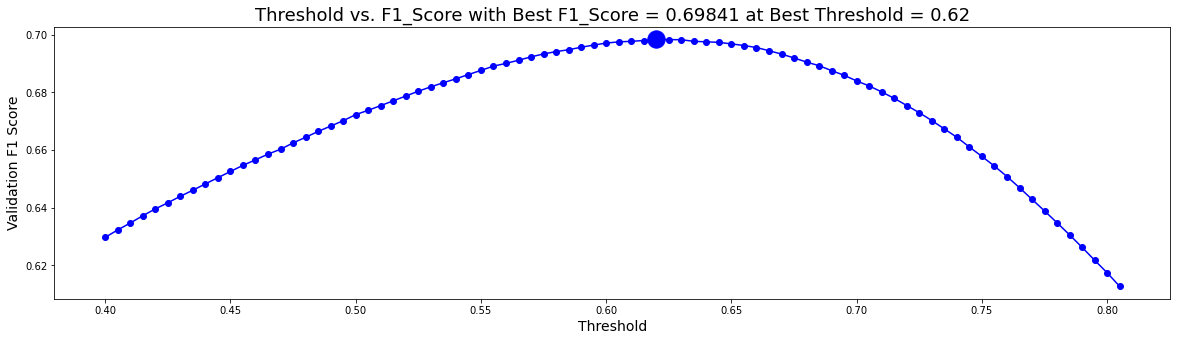

In [31]:
true = oof_xgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()

In [32]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[f'meta_{k+1}'].values, (oof_xgb[f'meta_{k+1}'].values>best_threshold_xgb).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof_xgb.values.reshape((-1))>best_threshold_xgb).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.674697478729699
Q1: F1 = 0.5204304768446963
Q2: F1 = 0.5216709410107748
Q3: F1 = 0.6838986025282698
Q4: F1 = 0.6404432334883597
Q5: F1 = 0.6429107757281071
Q6: F1 = 0.6302778323683822
Q7: F1 = 0.5704308330915628
Q8: F1 = 0.6326966600006964
Q9: F1 = 0.5884330971998586
Q10: F1 = 0.610318039297027
Q11: F1 = 0.5147761369864596
Q12: F1 = 0.48092479776290825
Q13: F1 = 0.6415673526068135
Q14: F1 = 0.6172348299224248
Q15: F1 = 0.4944334891087425
Q16: F1 = 0.553656279893989
Q17: F1 = 0.49733306545334977
==> Overall F1 = 0.6984056848367872


In [33]:
xgb_params

{'booster': 'gbtree',
 'objective': 'binary:logistic',
 'tree_method': 'gpu_hist',
 'eval_metric': 'logloss',
 'learning_rate': 0.01,
 'alpha': 8,
 'max_depth': 5,
 'n_estimators': 2000,
 'early_stopping_rounds': 90,
 'subsample': 0.8,
 'colsample_bytree': 0.5,
 'seed': 42}

In [34]:
%%time
# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df4
        FEATURES = FEATURES4
    elif t<=22: 
        grp = '13-22'
        df = df6
        FEATURES = FEATURES6
    
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
         'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.01,
        'alpha': 8,
        'max_depth': 5,
        'n_estimators': n_estimators,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'XGB_question{t}.json')
    
    print()

#########################
### question 1 features 745

#########################
### question 2 features 745

#########################
### question 3 features 745

#########################
### question 4 features 1861

#########################
### question 5 features 1861

#########################
### question 6 features 1861

#########################
### question 7 features 1861

#########################
### question 8 features 1861

#########################
### question 9 features 1861

#########################
### question 10 features 1861

#########################
### question 11 features 1861

#########################
### question 12 features 1861

#########################
### question 13 features 1861

#########################
### question 14 features 3180

#########################
### question 15 features 3180

#########################
### question 16 features 3180

#########################
### question 17 features 3180

#########################
### question 18 f

In [35]:
import pickle

In [36]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES4
    elif t<=22:
        importance_dict[str(t)] = FEATURES6

f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

In [37]:
len(importance_dict['12'])

1861

In [38]:
# %%time
# # ITERATE THRU QUESTIONS 1 THRU 18
# for t in range(1,19):

#     # USE THIS TRAIN DATA WITH THESE QUESTIONS
#     if t<=3: 
#         grp = '0-4'
#         df = df1
#         FEATURES = FEATURES1
#     elif t<=13: 
#         grp = '5-12'
#         df = df4
#         FEATURES = FEATURES4
#     elif t<=22: 
#         grp = '13-22'
#         df = df5
#         FEATURES = FEATURES5
    
#     n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    
#     print('#'*25)
#     print(f'### question {t} features {len(FEATURES)}')
        
#     # TRAIN DATA
#     train_users = df.index.values
#     train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

#     # TRAIN MODEL        
#     clf = CatBoostClassifier(
#             iterations = n_estimators,
#             early_stopping_rounds = 50,
#             depth = 4,
#             learning_rate = 0.03,
#             loss_function = "Logloss",
#             random_seed = 0,
#             metric_period = 1,
#             subsample = 0.8,
#             colsample_bylevel = 0.4,
#             verbose = 100)
        
#     clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
#     clf.save_model(f'CB_question{t}.json')
    
#     print()


In [39]:
n_estimators

772